In [23]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report , confusion_matrix
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [24]:
!ls

cell-images-for-detecting-malaria.zip  kaggle.json
cell_images.zip			       sample_data


In [25]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [26]:
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria
!unzip -q cell-images-for-detecting-malaria.zip

Dataset URL: https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria
License(s): unknown
cell-images-for-detecting-malaria.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!ls

cell_images			       cell_images.zip	sample_data
cell-images-for-detecting-malaria.zip  kaggle.json


In [27]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10

In [33]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

train_data = datagen.flow_from_directory(
    "cell_images",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="training"
)

val_data = datagen.flow_from_directory(
    "cell_images",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="validation"
)

Found 22048 images belonging to 2 classes.
Found 5510 images belonging to 2 classes.


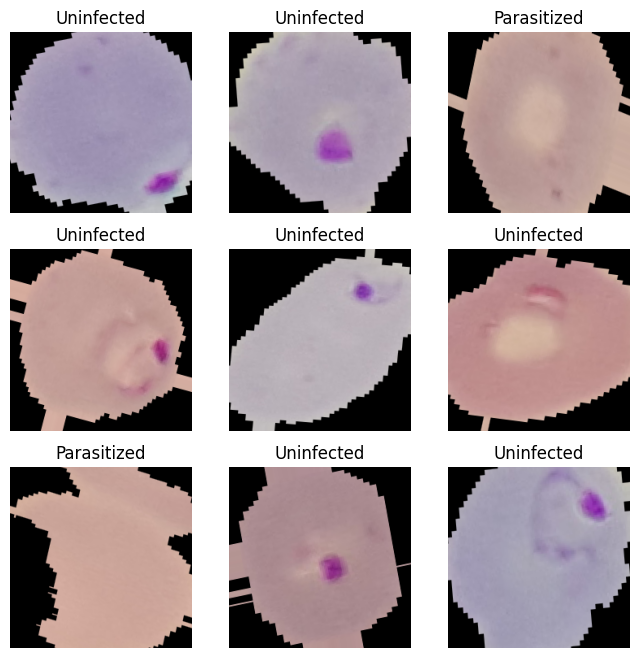

In [34]:
images, labels = next(train_data)

plt.figure(figsize=(8,8))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i])
    plt.title("Parasitized" if labels[i]==1 else "Uninfected")
    plt.axis("off")
plt.show()

In [30]:
import shutil
import os

# 1. Double check the name of the 'extra' folder in your sidebar
# Let's say the extra folder is named 'cell_images' (inside the main cell_images)
folder_to_remove = 'cell_images/cell_images'

if os.path.exists(folder_to_remove):
    shutil.rmtree(folder_to_remove) # This 'trees' through and deletes everything inside
    print("Done! The folder and all its files have been deleted.")
else:
    print("Folder not found. Make sure the path is correct!")

Done! The folder and all its files have been deleted.


In [35]:
base_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(224,224,3)
)

base_model.trainable = False  # Freeze pretrained layers

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [37]:
# Run this cell right before model.fit()
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [38]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    batch_size=32
)

Epoch 1/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.8843 - loss: 0.2820

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


689/689 ━━━━━━━━━━━━━━━━━━━━ 332s 470ms/step - accuracy: 0.8843 - loss: 0.2819 - val_accuracy: 0.9151 - val_loss: 0.2194
Epoch 2/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 306s 445ms/step - accuracy: 0.9263 - loss: 0.2035 - val_accuracy: 0.9185 - val_loss: 0.2176
Epoch 3/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 323s 469ms/step - accuracy: 0.9299 - loss: 0.1937 - val_accuracy: 0.9261 - val_loss: 0.2034
Epoch 4/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 307s 446ms/step - accuracy: 0.9362 - loss: 0.1813 - val_accuracy: 0.9205 - val_loss: 0.2122
Epoch 5/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 313s 454ms/step - accuracy: 0.9339 - loss: 0.1833 - val_accuracy: 0.9256 - val_loss: 0.1932
Epoch 6/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 308s 447ms/step - accuracy: 0.9332 - loss: 0.1794 - val_accuracy: 0.9269 - val_loss: 0.1921
Epoch 7/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 308s 446ms/step - accuracy: 0.9391 - loss: 0.1720 - val_accuracy: 0.9267 - val_loss: 0.1969
Epoch 8/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 311s 451ms/step - accuracy: 0.9403 - loss: 0.16

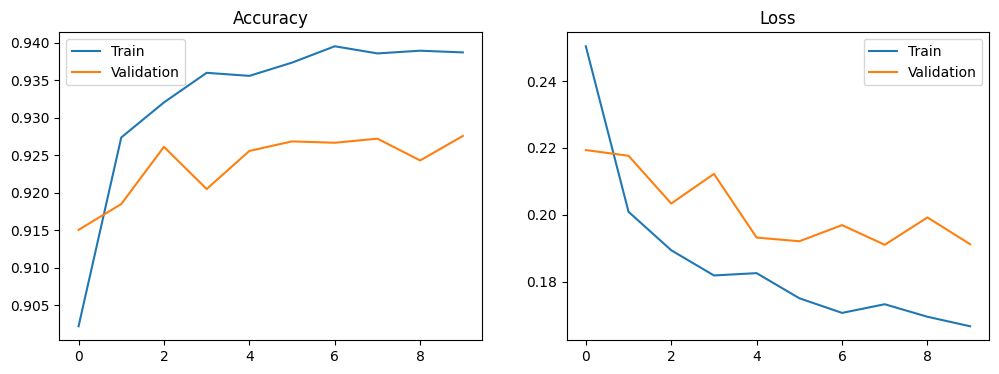

In [39]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.legend()

plt.show()


In [40]:
val_data.reset()
preds = model.predict(val_data)
y_pred = (preds > 0.5).astype(int)
y_true = val_data.classes

print(classification_report(y_true, y_pred, target_names=["Uninfected","Parasitized"]))

173/173 ━━━━━━━━━━━━━━━━━━━━ 71s 382ms/step
              precision    recall  f1-score   support

  Uninfected       0.50      0.49      0.50      2755
 Parasitized       0.50      0.51      0.51      2755

    accuracy                           0.50      5510
   macro avg       0.50      0.50      0.50      5510
weighted avg       0.50      0.50      0.50      5510



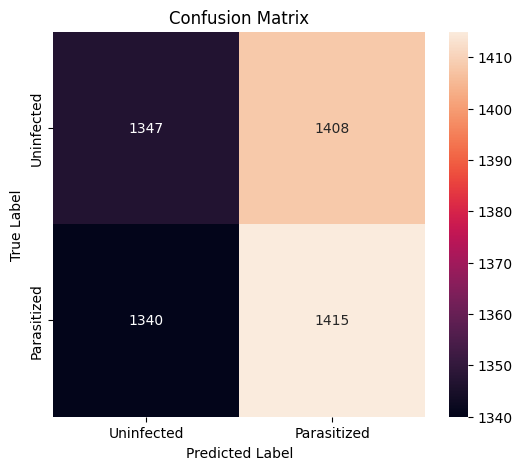

In [41]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=["Uninfected","Parasitized"],
            yticklabels=["Uninfected","Parasitized"])
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.title("Confusion Matrix")
plt.show()

In [43]:
model.save("malaria_detection_model.keras")